## 1. Importing libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import scipy

In [27]:
import lifelines

In [36]:
from sklearn.model_selection import train_test_split

In [2]:
## Get Data
df = pd.read_csv("stanford_heart_transplant_dataset_full.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PATIENT_ID                   103 non-null    int64  
 1   YR_OF_ACCEPTANCE             103 non-null    int64  
 2   AGE                          103 non-null    int64  
 3   SURVIVAL_STATUS              103 non-null    int64  
 4   SURVIVAL_TIME                103 non-null    int64  
 5   PRIOR_SURGERY                103 non-null    int64  
 6   TRANSPLANT_STATUS            103 non-null    int64  
 7   WAITING_TIME_FOR_TRANSPLANT  69 non-null     float64
 8   MISMATCH_ON_ALLELES          69 non-null     float64
 9   MISMATCH_ON_ANTIGEN          69 non-null     float64
 10  MISMATCH_SCORE               43 non-null     float64
dtypes: float64(4), int64(7)
memory usage: 9.0 KB


In [3]:
df.head(5)

,PATIENT_ID,YR_OF_ACCEPTANCE,AGE,SURVIVAL_STATUS,SURVIVAL_TIME,PRIOR_SURGERY,TRANSPLANT_STATUS,WAITING_TIME_FOR_TRANSPLANT,MISMATCH_ON_ALLELES,MISMATCH_ON_ANTIGEN,MISMATCH_SCORE
0,15,68,53,1,1,0,0,NaN,NaN,NaN,NaN
1,43,70,43,1,2,0,0,NaN,NaN,NaN,NaN
2,61,71,52,1,2,0,0,NaN,NaN,NaN,NaN
3,75,72,52,1,2,0,0,NaN,NaN,NaN,NaN
4,6,68,54,1,3,0,0,NaN,NaN,NaN,NaN


In [34]:
df.PATIENT_ID.value_counts().unique()

array([2, 1])

In [5]:
df.AGE.value_counts().sort_index()

AGE
8      1
19     1
20     2
23     1
26     2
28     1
29     2
30     2
32     1
33     1
35     1
36     3
38     1
39     2
40     4
41     5
42     4
43     4
44     2
45     4
46     2
47    11
48     8
49     4
50     3
51     4
52     7
53     7
54     5
55     1
56     3
58     1
59     1
61     1
64     1
Name: count, dtype: int64

In [8]:
df.groupby("SURVIVAL_TIME").SURVIVAL_STATUS.value_counts()

SURVIVAL_TIME  SURVIVAL_STATUS
1              1                  1
2              1                  3
3              1                  3
5              1                  2
6              1                  2
                                 ..
1400           0                  1
1407           0                  1
1571           0                  1
1586           0                  1
1799           0                  1
Name: count, Length: 90, dtype: int64

## Model Fitting

### Agnostic to boolean variable: have/ haven't had prior heart surgery

In [10]:
kmf = KaplanMeierFitter(label='Stanford heart transplant dataset')
kmf?

Type:        KaplanMeierFitter
String form: <lifelines.KaplanMeierFitter>
File:        ~/Desktop/Projects/.venv/lib/python3.8/site-packages/lifelines/fitters/kaplan_meier_fitter.py
Docstring:  
Class for fitting the Kaplan-Meier estimate for the survival function.

Parameters
----------
alpha: float, optional (default=0.05)
    The alpha value associated with the confidence intervals.
label: string, optional
    Provide a new label for the estimate - useful if looking at many groups.

Examples
--------
.. code:: python

    from lifelines import KaplanMeierFitter
    from lifelines.datasets import load_waltons
    waltons = load_waltons()

    kmf = KaplanMeierFitter(label="waltons_data")
    kmf.fit(waltons['T'], waltons['E'])
    kmf.plot()


Attributes
----------
survival_function_ : DataFrame
    The estimated survival function (with custom timeline if provided)
median_survival_time_ : float
    The estimated median time to event. np.inf if doesn't exist.
confidence_interval_ : Dat

Text(0, 0.5, 'Survival probability')

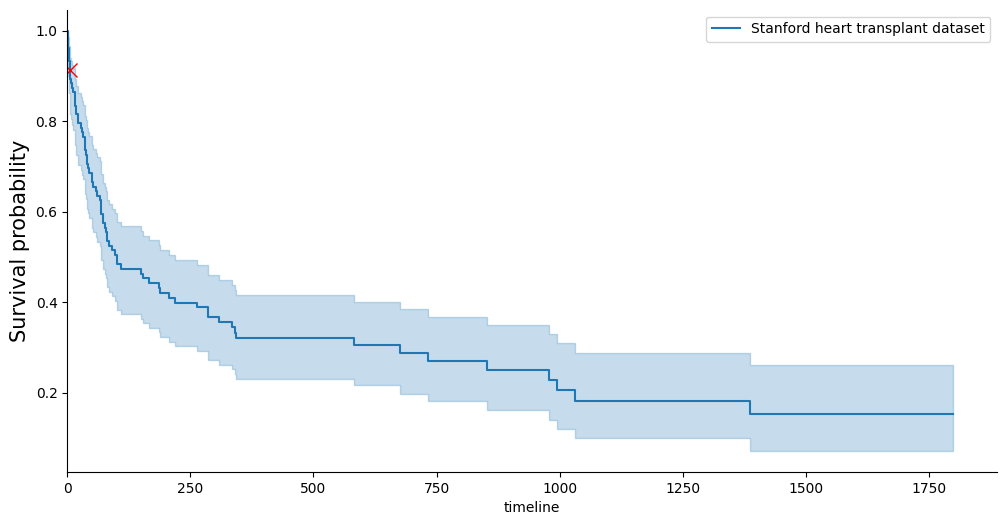

In [23]:
kmf = kmf.fit(durations=df['SURVIVAL_TIME'], event_observed=df['SURVIVAL_STATUS'])
predict_val = kmf.predict(6)

fig, ax = plt.subplots(figsize=(12,6))
ax = kmf.plot()
ax.plot(6, 0.9126, color='red', marker='x', markeredgewidth=1, markersize=10)
ax.set_xlim(0,None)
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Survival probability", fontsize=15)

### Sensitive to the prior surgery

In [24]:
idx = df['PRIOR_SURGERY'] == 1

In [25]:
kmf_w_prior_surgery = KaplanMeierFitter(label='Group with prior heart surgery').fit(
    durations=df[idx]['SURVIVAL_TIME'], event_observed=df[idx]['SURVIVAL_STATUS'])

kmf_wo_prior_surgery = KaplanMeierFitter(label='Group with prior heart surgery').fit(
    durations=df[~idx]['SURVIVAL_TIME'], event_observed=df[~idx]['SURVIVAL_STATUS'])

Text(0, 0.5, 'Survival probability')

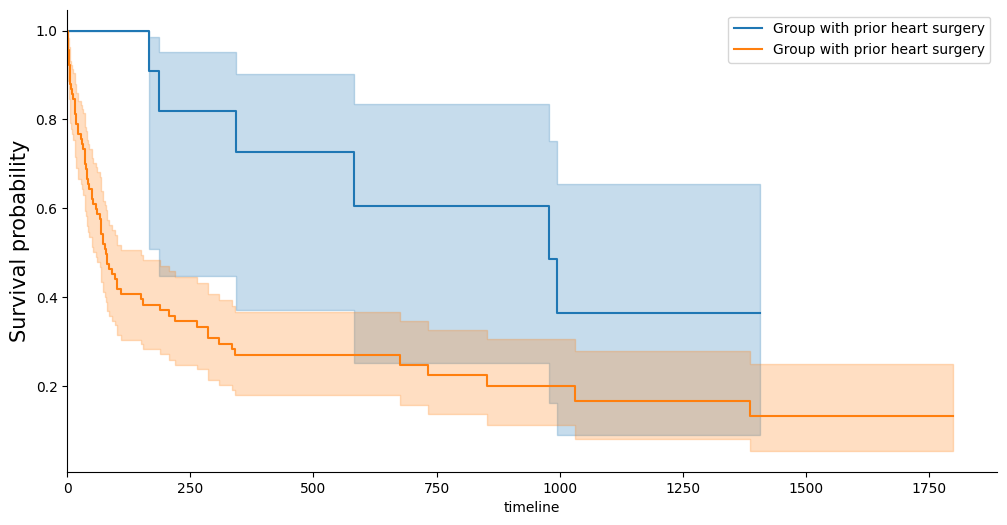

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ax = kmf_w_prior_surgery.plot()
ax = kmf_wo_prior_surgery.plot()
ax.set_xlim(0,None)
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Survival probability", fontsize=15)



In [31]:
lifelines.statistics.survival_difference_at_fixed_point_in_time_test?

Signature:
lifelines.statistics.survival_difference_at_fixed_point_in_time_test(
    point_in_time,
    fitterA,
    fitterB,
    **result_kwargs,
) -> lifelines.statistics.StatisticalResult
Docstring:
Often analysts want to compare the survival-ness of groups at specific times, rather than comparing the entire survival curves against each other.
For example, analysts may be interested in 5-year survival. Statistically comparing the naive Kaplan-Meier points at a specific time
actually has reduced power (see [1]). By transforming the survival function, we can recover more power. This function uses
the log(-log(·)) transformation.


Parameters
----------
point_in_time: float,
    the point in time to analyze the survival curves at.

fitterA:
    A lifelines univariate model fitted to the data. This can be a ``KaplanMeierFitter``, ``WeibullFitter``, etc.

fitterB:
    the second lifelines model to compare against.

result_kwargs:
    add keywords and meta-data to the experiment summary



In [32]:
lifelines.statistics.survival_difference_at_fixed_point_in_time_test(
    point_in_time=365,
    fitterA = kmf_w_prior_surgery,
    fitterB = kmf_wo_prior_surgery)

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 365
           fitterA = <lifelines.KaplanMeierFitter:"Group with prior heart surgery", fitted with 12 total observations, 6 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"Group with prior heart surgery", fitted with 91 total observations, 22 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           5.65 0.02      5.84

### Cox proportional hazards model

The goal of our regression model is to estimate the expected survival duration y given the regression variables X, and in doing so, calculate the influence of each regression variable AGE, PRIOR_SURGERY and TRANSPLANT_STATUS on SURVIVAL_TIME.

In [35]:
df2 = df[['AGE', 'PRIOR_SURGERY', 'TRANSPLANT_STATUS', 'SURVIVAL_TIME', 'SURVIVAL_STATUS']]
df2.head(5)

,AGE,PRIOR_SURGERY,TRANSPLANT_STATUS,SURVIVAL_TIME,SURVIVAL_STATUS
0,53,0,0,1,1
1,43,0,0,2,1
2,52,0,0,2,1
3,52,0,0,2,1
4,54,0,0,3,1


In [37]:
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [40]:
df2_train, df2_test = train_test_split(df2, test_size = 0.2)

In [41]:
# Sanity check
df2_train.shape[0] / df2.shape[0]

0.7961165048543689

In [43]:
cph_model = lifelines.CoxPHFitter()
cph_model??


Type:        CoxPHFitter
String form: <lifelines.CoxPHFitter>
File:        ~/Desktop/Projects/.venv/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py
Source:     
class CoxPHFitter(RegressionFitter, ProportionalHazardMixin):
    r"""
    This class implements fitting Cox's proportional hazard model.

    .. math::  h(t|x) = h_0(t) \exp((x - \overline{x})' \beta)

    The baseline hazard, :math:`h_0(t)` can be modeled in two ways:

    1. (default) non-parametrically, using Breslow's method. In this case, the entire model is the traditional semi-parametric Cox model. Ties are
    handled using Efron's method.

    2. parametrically, using a pre-specified number of cubic splines, or piecewise values.

    This is specified using the ``baseline_estimation_method`` parameter in the initialization (default = ``"breslow"``)

    Parameters
    ----------

      alpha: float, optional (default=0.05)
        the level in the confidence intervals.

      baseline_estimation_method: 

In [44]:
cph_model.fit??

Signature:
cph_model.fit(
    df: 'pd.DataFrame',
    duration_col: 'Optional[str]' = None,
    event_col: 'Optional[str]' = None,
    show_progress: 'bool' = False,
    initial_point: 'Optional[ndarray]' = None,
    strata: 'Optional[Union[str, List[str]]]' = None,
    weights_col: 'Optional[str]' = None,
    cluster_col: 'Optional[str]' = None,
    robust: 'bool' = False,
    batch_mode: 'Optional[bool]' = None,
    timeline: 'Optional[Iterator]' = None,
    formula: 'str' = None,
    entry_col: 'str' = None,
    fit_options: 'Optional[dict]' = None,
) -> 'CoxPHFitter'
Source:   
    @utils.CensoringType.right_censoring
    def fit(
        self,
        df: pd.DataFrame,
        duration_col: Optional[str] = None,
        event_col: Optional[str] = None,
        show_progress: bool = False,
        initial_point: Optional[ndarray] = None,
        strata: Optional[Union[str, List[str]]] = None,
        weights_col: Optional[str] = None,
        cluster_col: Optional[str] = None,
    

In [45]:
cph_model.fit(df=df2_train, duration_col='SURVIVAL_TIME', event_col='SURVIVAL_STATUS')

<lifelines.CoxPHFitter: fitted with 82 total observations, 23 right-censored observations>

In [46]:
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 82 total observations, 23 right-censored observations>
             duration col = 'SURVIVAL_TIME'
                event col = 'SURVIVAL_STATUS'
      baseline estimation = breslow
   number of observations = 82
number of events observed = 59
   partial log-likelihood = -198.76
         time fit was run = 2024-05-18 19:00:35 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
AGE                 0.05       1.06       0.02             0.02             0.09                 1.02                 1.09
PRIOR_SURGERY      -0.70       0.49       0.54            -1.76             0.35                 0.17                 1.42
TRANSPLANT_STATUS  -1.86       0.16       0.31            -2.47            -1.25                 0.08                 0.29

                    cmp to     z      p   -log2(p)
covariate                                         
AGE                   0.00  3.33 <0.005      10.17
PRIOR_SURGERY         0.00 -1.31   0.19       2.39
TRANSPLANT_STATUS     0.00 -5.96 <0.005      28.54
---
Concordance = 0.75
Partial AIC = 403.52
log-likelihood ratio test = 43.09 on 3 df
-log2(p) of ll-ratio test = 28.66

In [47]:
expected_survival_times = cph_model.predict_expectation(df2_test)

Text(0.5, 0, 'Predicted Survival times')

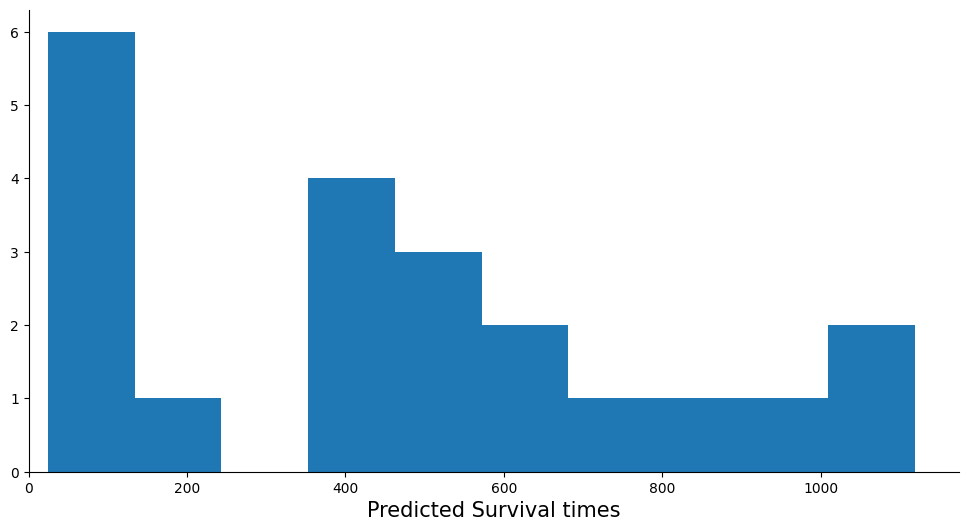

In [52]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(expected_survival_times)
ax.set_xlim(0,None)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("Predicted Survival times", fontsize=15)


Text(0, 0.5, 'Predicted Survival times')

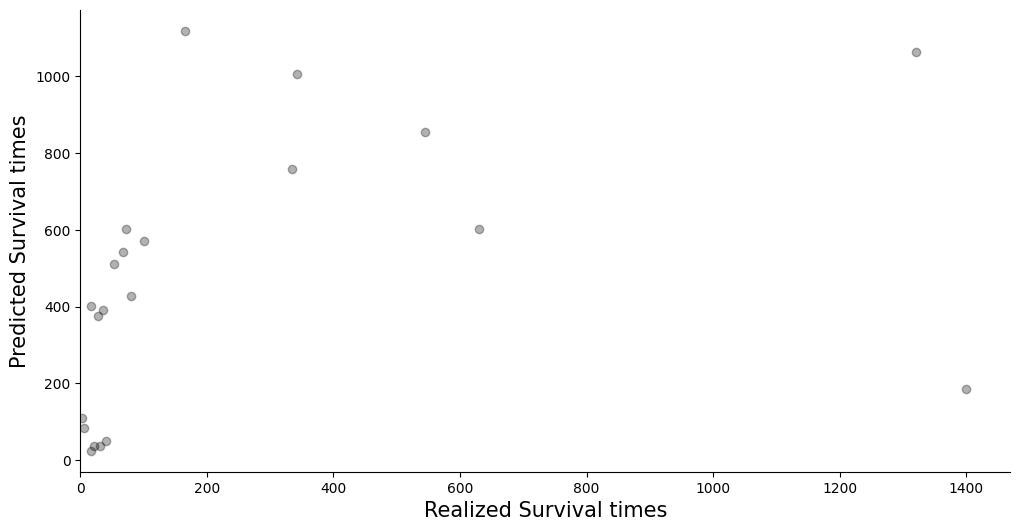

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df2_test.SURVIVAL_TIME.values, expected_survival_times, color="k", alpha = 0.3)
ax.set_xlim(0,None)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("Realized Survival times", fontsize=15)
ax.set_ylabel("Predicted Survival times", fontsize=15)

In [56]:
# Not a great fit but ranking is good
scipy.stats.spearmanr(df2_test.SURVIVAL_TIME.values, expected_survival_times)

SignificanceResult(statistic=0.731881741607999, pvalue=0.00016253074127433613)

In [48]:
dir(cph_model)

['AIC_',
 'AIC_partial_',
 '_ALLOWED_RESIDUALS',
 '_FAST_MEDIAN_PREDICT',
 '_KNOWN_MODEL',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_mode',
 '_censoring_type',
 '_central_values',
 '_check_values_post_fitting',
 '_check_values_pre_fitting',
 '_choose_gradient_calculator',
 '_class_name',
 '_clusters',
 '_compute_baseline_cumulative_hazard',
 '_compute_baseline_hazard',
 '_compute_baseline_hazards',
 '_compute_baseline_survival',
 '_compute_central_values_of_raw_training_data',
 '_compute_confidence_intervals',
 '_compute_delta_beta',
 '_compute_deviance',
 '_compute_martingale',
 '_compute_p_values',
 '_compute_sandwich_estimator',
 '_